# Introduction

I've already made several notebooks looking at the NYC 2015 Tree Census dataset. In this notebook, I'll start trying to do some more serious work at trying to extract meaningful results from this data. In particular, I'll look at two specific problems:

  1) Can we predict the borough of a place in NYC just using the types of trees in the area?
  
  2) Do the trees tell us anything about things like the income of the area?
  
Basically, I want to see what something as mundane as the species of street trees might tell us about the urban environment. Are the boroughs distinct? Do certain trees appear in certain kinds of neighborhoods? Obviously, street trees are planted by the city, so someone is making these kinds of choices. But, without any specialized training in botany or in urban planning, can I discover these kinds of choices made by city planners? This sort of analysis is not just possible for trees. Any kind of geospatial data can be used. Things like what kinds of architecture appear in a neighborhood or what kinds of cars are parked on the street could also be used to ask similar questions. With the right data set, there may be many interesting insights for people such as urban planners and real estate analysts.

Some techniques that I show here include:

  - DataFrame Joins
  - Data Aggregation (groupby)
  - Count vectorization (i.e. Term Frequency matrix)
  - Naive Bayes classification
  - Singular value decomposition (SVD)
  - Decision tree regression (including ensemble methods)

# Data Preparation

The data is in a CSV file, so we'll first read it in with pandas. Next, we'll extract the census tract, strip whitespace from the tree species names, and create a reduced DataFrame of living trees with their corresponding census tracts.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
trees = pd.read_csv("data/street_trees_2015.csv")
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 41 columns):
tree_id       683788 non-null int64
block_id      683788 non-null int64
created_at    683788 non-null object
tree_dbh      683788 non-null int64
stump_diam    683788 non-null int64
curb_loc      683788 non-null object
status        683788 non-null object
health        652172 non-null object
spc_latin     652169 non-null object
spc_common    652169 non-null object
steward       652173 non-null object
guards        652172 non-null object
sidewalk      652172 non-null object
user_type     683788 non-null object
problems      652124 non-null object
root_stone    683788 non-null object
root_grate    683788 non-null object
root_other    683788 non-null object
trunk_wire    683788 non-null object
trnk_light    683788 non-null object
trnk_other    683788 non-null object
brch_light    683788 non-null object
brch_shoe     683788 non-null object
brch_other    683788 non-null object
addre

In [3]:
# Manhattan: 1, Bronx: 2, Brooklyn: 3, Queens: 4, Staten Island: 5
boromap = {'1':'36061','2':'36005','3':'36047','4':'36081','5':'36085'}
boromap_inv = {'36061':1,'36005':2,'36047':3,'36081':4,'36085':5}

def get_tract(boro_ct):
    boro_ct = str(boro_ct)
    return int(boromap[boro_ct[0]] + boro_ct[1:])
trees['tract'] = trees.boro_ct.map(get_tract)

trees = trees[trees.status=='Alive']
trees = trees[['spc_common','tract']]
trees.spc_common = trees.spc_common.map(lambda x : str(x).replace(' ','_').replace('','') )

# Census Data

Now that we have a list of street trees, we also want to look at income. I have already prepared a census data file, so I can read it, reduce to just the tract ID and median household income. Finally, we will do an inner join with the trees DataFrame. This will leave us with a DataFrame in the form [tree, tract, tract_income].

In [4]:
census = pd.read_csv('data/nyc_census_tracts.csv')
census.head()

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


In [5]:
census = census.loc[pd.notnull(census.Income),['CensusTract','Income'] ]

In [6]:
trees_census = pd.merge(census,trees,left_on='CensusTract',right_on='tract',copy=False)
trees_census = trees_census[['tract','Income','spc_common']]
trees_census.head()

,tract,Income,spc_common
0,36005000200,72034.0,American_linden
1,36005000200,72034.0,American_linden
2,36005000200,72034.0,silver_linden
3,36005000200,72034.0,silver_linden
4,36005000200,72034.0,silver_maple


# Predicting Borough From Tree Distribution

First, I'll try to use the tree information to predict the borough of a census tract. To do this, I need to aggregate the tree information for each census tract. This is easily done with the  DataFrame.groupby() function. My target will be the borough, so I'll also extract that from the tract.

In [7]:
tract_list = []
tract_trees = {'trees':[],'income':[],'boro':[]}
boromap_inv = {'36061':1,'36005':2,'36047':3,'36081':4,'36085':5}

for tract,group in trees_census.groupby('tract'):

    tract_list.append(tract)
    tract_trees['trees'].append(' '.join(list(group.spc_common)) )
    tract_trees['income'].append(group.Income.mean())
    tract_trees['boro'].append(boromap_inv[str(tract)[:5]])
    
tract_trees = pd.DataFrame(tract_trees,index=tract_list)

In [8]:
tract_trees.head()

,boro,income,trees
36005000200,2,72034.0,American_linden American_linden silver_linden ...
36005000400,2,74836.0,red_maple Callery_pear red_maple Callery_pear ...
36005001600,2,32312.0,ginkgo cherry purple-leaf_plum pin_oak ginkgo ...
36005001900,2,37936.0,honeylocust honeylocust Sophora Callery_pear C...
36005002000,2,18086.0,sugar_maple sugar_maple London_planetree Calle...


To make the prediction, I'll create a pipeline that first runs the CountVectorizer() and then runs a Multinomial Naive Bayes classifier. I will use GridSearchCV to cross-validate the hyperparameters and then run the model on a separate test set.

Why Naive Bayes? First, a multinomial distribution will be a natural way to represent the statistics related to CountVectorizer output. However, we have over 100 features and fewer than 3000 samples, so most classification methods are very likely to overfit. Naive Bayes models avoid this by treating each individual feature separately. It loses all information about correlations, but provides a nice out-of-the-box method that needs little tuning.

I've purposely created the "trees" feature as a string so that I can make use of NLP techniques. Alternatively, I could have used a one-hot encoding with get_dummies() from pandas or OneHotEncoder in sklearn.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [10]:
X = tract_trees['trees']
y = tract_trees['boro']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=432)

cvec = CountVectorizer(token_pattern='\S+')
mnb = MultinomialNB()
pipeline = Pipeline([['Counts',cvec],['NaiveBayes',mnb]])

I'll do the cross validation on the minimum "document" (i.e. tract) frequency and on the regularization parameter of the NB model.

In [11]:
params = {'Counts__min_df':np.linspace(0.001,.1,5),'NaiveBayes__alpha':np.logspace(-2,1,5)}
gsv = GridSearchCV(pipeline,params,scoring='accuracy',cv=5)

In [12]:
gsv.fit(X_train,y_train)

print(gsv.best_params_)
print(gsv.best_score_)

{'Counts__min_df': 0.075250000000000011, 'NaiveBayes__alpha': 1.7782794100389228}
0.683551847437


It actually turns out that the accuracy score isn't particularly sensitive to these parameters. Now, I can see the results on the test set. I'll record the top two guesses, whether they are correct, and the probabilities.

In [13]:
yprob = gsv.predict_proba(X_test)
yguess = gsv.predict(X_test)

In [14]:
boropred = pd.DataFrame()
boropred['truth'] = y_test
for i in range(1,6):
    boropred['prob{}'.format(i)] = yprob[:,i-1]
boropred.index.name = 'tract'
boropred['guess1'] = np.argmax(boropred.values[:,1:6],axis=1)+1
boropred['guess2'] = np.argsort(boropred.values[:,1:6],axis=1)[:,3]+1
boropred['corBest'] = (boropred.truth==boropred.guess1)
boropred['corBest2'] = np.array(boropred.corBest) + np.array((boropred.truth==boropred.guess2))
boropred['probBest'] = boropred.corBest * np.array([entry[entry[6]] for entry in boropred.values])
boropred['probBest2'] = boropred.corBest2 * np.array(boropred.probBest) + np.array([entry[entry[7]] for entry in boropred.values])
boropred.corBest = boropred.corBest*1
boropred.corBest2 = boropred.corBest2*1

#boropred['loglossBest'] = boropred.corBest *np.log(boropred.probBest+1e-10)
#boropred['loglossBest2'] = boropred.corBest2 * np.log(boropred.probBest2+1e-10)

In [15]:
print('Weighted probability of top guess: {}'.format(boropred.probBest.mean()))
print('Weighted probability of top 2 guesses: {}'.format(boropred.probBest2.mean()))

Weighted probability of top guess: 0.642545253704983
Weighted probability of top 2 guesses: 0.6710937485724188


It looks like we get the right answer almost 2/3 of the time! Adding the top two guesses in only slightly better, which is a bit surprising. However, we optimized the accuracy score, so maybe this is expected. If we look at the training data, we also see that the second guess has been overfit, so it provides little information to the test set.

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


Of course, the different boroughs are not equal. The number of census tracts is roughly proportional to the population, so Brooklyn and Queens will have the most tracts and Staten Island the least. We need to make sure that our classifier is not just trying to predict Brooklyn or Queens for nearly every entry. This is a good job for a classification matrix. I will plot the matrix, but after normalizing (1) the rows to see how a tree from a given borough is typically classified and (2) the columns to see where trees predicted to be in a particular borough are actually located.

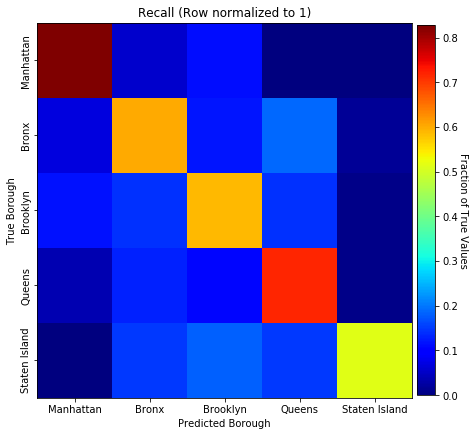

In [17]:
conf_mat = 1.0*(confusion_matrix(y_test,yguess))
norms = np.sum(conf_mat,axis=1)
for i in range(5):
    conf_mat[i,:] = conf_mat[i,:]/norms[i]
fig = plt.figure(1,figsize=(8,8))
plt.imshow(conf_mat,cmap='jet')
plt.xticks(np.arange(5),['Manhattan','Bronx','Brooklyn','Queens','Staten Island'])
plt.yticks(np.arange(5),['Manhattan','Bronx','Brooklyn','Queens','Staten Island'],
           rotation=90,rotation_mode='anchor',ha='center')
plt.ylabel('True Borough')
plt.xlabel('Predicted Borough')
plt.title('Recall (Row normalized to 1)')
cbar = plt.colorbar(shrink=0.85,pad=0.01)
cbar.set_label('Fraction of True Values',rotation=270,labelpad=10)
plt.show()

Here, note that each row is normalized to 1. This shows us that we get trees in Staten Island right about 50% of the time but do substantially better for the other boroughs.

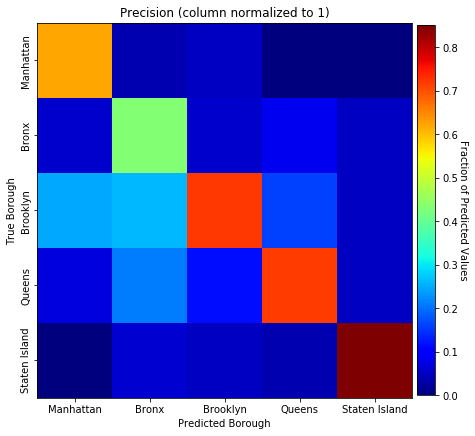

In [18]:
conf_mat = 1.0*(confusion_matrix(y_test,yguess))
norms = np.sum(conf_mat,axis=0)
for i in range(5):
    conf_mat[:,i] = conf_mat[:,i]/norms[i]
fig = plt.figure(1,figsize=(8,8))
plt.imshow(conf_mat,cmap='jet')
plt.xticks(np.arange(5),['Manhattan','Bronx','Brooklyn','Queens','Staten Island'])
plt.yticks(np.arange(5),['Manhattan','Bronx','Brooklyn','Queens','Staten Island'],
           rotation=90,rotation_mode='anchor',ha='center')
plt.ylabel('True Borough')
plt.xlabel('Predicted Borough')
plt.title('Precision (column normalized to 1)')
cbar = plt.colorbar(shrink=0.85,pad=0.01)
cbar.set_label('Fraction of Predicted Values',rotation=270,labelpad=10)
plt.show()

Here we see that while Manhattan had the best recall and Staten Island the worst, Staten Island has the best precision and the Bronx the worst. But even for the Bronx, the precision is over 40%, with the number well over 50% for the other boroughs.

# Mapping the Results

Now, we should map the results. This requires running over the full dataset if we want to get a city-wide map. I'll first look at the confusion matrix as above and then I'll make the maps using my mapping & plotting tools.

In [19]:
from nyc.mapping import CensusTractMapper
from nyc.plotting import MapPlotter

In [20]:
yprob = gsv.predict_proba(X)
yguess = gsv.predict(X)
boropred = pd.DataFrame()
boropred['truth'] = y
for i in range(1,6):
    boropred['prob{}'.format(i)] = yprob[:,i-1]
boropred.index.name = 'tract'
boropred['guess1'] = np.argmax(boropred.values[:,1:6],axis=1)+1
boropred['guess2'] = np.argsort(boropred.values[:,1:6],axis=1)[:,3]+1
boropred['corBest'] = (boropred.truth==boropred.guess1)
boropred['corBest2'] = np.array(boropred.corBest) + np.array((boropred.truth==boropred.guess2))
boropred['probBest'] = boropred.corBest * np.array([entry[entry[6]] for entry in boropred.values])
boropred['probBest2'] = boropred.corBest2 * np.array(boropred.probBest) + np.array([entry[entry[7]] for entry in boropred.values])
boropred.corBest = boropred.corBest*1
boropred.corBest2 = boropred.corBest2*1

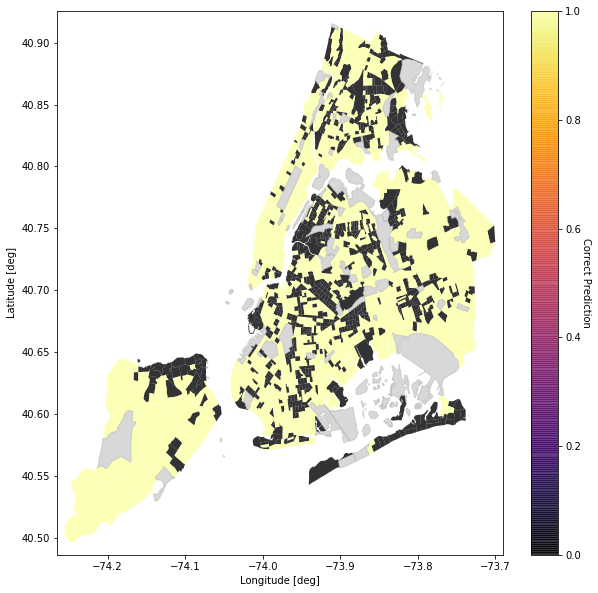

In [21]:
nm = CensusTractMapper(path='data/census_tracts.shp')
mp = MapPlotter(nm)

fig = plt.figure(1,figsize=[10,10])
ax = fig.add_subplot(111)

mp.plot(boropred['corBest'],ax=ax)
mp.cbar.set_label('Correct Prediction',rotation=270,labelpad=10)
plt.show()

We can see that the places we get wrong don't look very random. There are a number of fairly compact clusters of tracts that are wrong, such as the upper tip of Staten Island, the Rockaways, Bushwick, Cypress Hills, and around Newtown Creek. Some of these are on the boundaries between two boroughs and others (like the area in Staten Island) are actually quite different from the rest of the borough.

This very strongly suggests that the output of the Multinomial Naive Bayes classifier is really telling us something about the urban environment of the census tract.

We can also look at the top two, but it turns out that the second highest probability is badly overfit.

# How Do Trees Relate to Census Demographic Information?

So it turns out that we can do a decent job of predicting the NYC borough from what kinds of trees are nearby. Now, let's see if maybe we can predict the income of an area. 

In [22]:
trees_income = {'mean':[],'median':[],'std':[],'count':[]}
spc_list = []

for spc,group in trees_census.groupby('spc_common'):
    spc_list.append(spc)
    trees_income['mean'].append(group.Income.mean())
    trees_income['median'].append(group.Income.median())
    trees_income['std'].append(group.Income.std())
    trees_income['count'].append(group.Income.count())

    
trees_income = pd.DataFrame(trees_income,index=spc_list)
trees_income.head()

,count,mean,median,std
'Schubert'_chokecherry,4877,63225.344884,61458.0,24108.885999
American_beech,271,60290.634686,58553.0,24391.844176
American_elm,7425,59750.050101,53495.0,30173.653968
American_hophornbeam,1072,59936.013060,56089.5,25131.301563
American_hornbeam,1510,60557.745695,61217.0,25701.287657


There is roughly a factor of 25 difference between the wealthiest and poorest census tracts, but the distribution is skewed. The peak is only around \$50-\$60k. We might expect that this search will be difficult but let's see what we can do anyway.

To do the prediction, we'll first do some feature reduction. We're starting with over 100 features (i.e. species) but only around 2000 census tracts, so to do anything sensible, we could use fewer components. So, I'll first run the CountVectorizer, then a TruncatedSVD to use an unsupervised technique to find 20 smaller features. Finally, I'll test out a few different models to try to fit the data.

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor

X = tract_trees.trees
y = tract_trees.income

# In the interest of time, just run the count vectorizer once
cvec = CountVectorizer(min_df = 10,token_pattern='\S+')
X = cvec.fit_transform(X)


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=432)

# 
svd = TruncatedSVD(n_components=20,random_state=5432)
svd.fit(X_train)
comp = svd.components_
mapping = cvec.get_feature_names()
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)

In [24]:
components = []

for c in comp:
    cmap = []
    for idx,val in enumerate(c):
        cmap.append( (val,mapping[idx]) )
        cmap = sorted(cmap,key=lambda x: x[0] ,reverse=True)
        cmap = cmap[:5] + cmap[-5:]
    components.append(cmap)

In [25]:
components

[[(0.6290692273557843, 'callery_pear'),
  (0.46085295099500451, 'london_planetree'),
  (0.2908303477157333, 'pin_oak'),
  (0.28495366292401891, 'honeylocust'),
  (0.24520464913762527, 'norway_maple'),
  (0.00025848282033059299, 'boxelder'),
  (0.00022325883168995643, 'black_pine'),
  (0.00019036771008284554, 'pitch_pine'),
  (0.00015342690809005518, 'scots_pine'),
  (0.00010611914614740529, 'osage-orange')],
 [(0.69155376611221253, 'callery_pear'),
  (0.10166092089694606, 'red_maple'),
  (0.08244567104787498, 'sweetgum'),
  (0.036254030725650171, 'silver_maple'),
  (0.021567569319008287, 'maple'),
  (-0.09876331620469346, 'norway_maple'),
  (-0.10799021082450085, 'littleleaf_linden'),
  (-0.18244295519332793, 'pin_oak'),
  (-0.18290978585896184, 'honeylocust'),
  (-0.62467007834042376, 'london_planetree')],
 [(0.54080884979519217, 'london_planetree'),
  (0.1422522170768335, 'callery_pear'),
  (0.06389380460649946, 'red_maple'),
  (0.04126145270367803, 'sweetgum'),
  (0.0391840114316740

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=3)
abr = AdaBoostRegressor(dtr,n_estimators=5000,learning_rate=0.0001,random_state=8439)
#abr.fit(X_train,y_train)
rfr = RandomForestRegressor(n_estimators=500,min_samples_leaf=15,max_depth=10)
#lr = LinearRegression()
#lr.fit(X_train,y_train)
rfr.fit(X_train,y_train)
y_predtrain = rfr.predict(X_train)
y_predtest = rfr.predict(X_test)

In [27]:
from sklearn import metrics

R2train = metrics.r2_score(y_train,y_predtrain)
R2test = metrics.r2_score(y_test,y_predtest)
print('R2 Score, Training Set: {:0.3}'.format(R2train))
print('R2 Score, Test Set: {:0.3}'.format(R2test))

R2 Score, Training Set: 0.492
R2 Score, Test Set: 0.25


I haven't done a detailed study, but the best model I've found so far is a Random Forest decision tree regressor. But, I see that I'm still overfitting and also only get an R^2 score of 0.25. Evidently, it's not so easy to get income from the tree features. While I haven't fully optimized everything, this suggests that there is at best a weak correlation. This is also complicated by the fact that we've already seen that tree species are likely highly correlated with the characteristics of the surrounding urban environment.

One last test I'll do here is to us ea TfidfVectorizer instead of the CountVectorizer. This will de-emphasize the effects of the most common trees.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = tract_trees.trees
y = tract_trees.income
tfidf = TfidfVectorizer(min_df = 5,token_pattern='\S+')
X = tfidf.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=432)
svd = TruncatedSVD(n_components=20,random_state=5432)
svd.fit(X_train)
comp = svd.components_
mapping = tfidf.get_feature_names()
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)

In [29]:
components = []

for c in comp:
    cmap = []
    for idx,val in enumerate(c):
        cmap.append( (val,mapping[idx]) )
        cmap = sorted(cmap,key=lambda x: x[0] ,reverse=True)
        cmap = cmap[:5] + cmap[-5:]
    components.append(cmap)
components

[[(0.55308582981116772, 'london_planetree'),
  (0.42156641907541648, 'honeylocust'),
  (0.33037233996002618, 'pin_oak'),
  (0.28616095400305397, 'callery_pear'),
  (0.22203601987131655, 'norway_maple'),
  (0.0010270041575303132, 'pitch_pine'),
  (0.00088529847338691394, 'osage-orange'),
  (0.0008788689672463441, 'scots_pine'),
  (0.00060731112959108756, 'virginia_pine'),
  (0.00022230311978342919, 'nan')],
 [(0.69518538220945392, 'london_planetree'),
  (0.15617414575804764, 'norway_maple'),
  (0.059598228801076125, 'silver_maple'),
  (0.038139867903918052, 'crimson_king_maple'),
  (0.023827200581944204, 'sycamore_maple'),
  (-0.13078793548335238, 'japanese_zelkova'),
  (-0.15595987675117279, 'sophora'),
  (-0.17444090935310544, 'ginkgo'),
  (-0.1892628297191799, 'callery_pear'),
  (-0.59509147464823375, 'honeylocust')],
 [(0.4921057075909307, 'pin_oak'),
  (0.334567233743498, 'norway_maple'),
  (0.2908709798844164, 'cherry'),
  (0.19303791278944177, 'callery_pear'),
  (0.15609019655151

In [30]:
dtr = DecisionTreeRegressor(max_depth=3)
#abr = AdaBoostRegressor(dtr,n_estimators=5000,learning_rate=0.0001,random_state=8439)
#abr.fit(X_train,y_train)
rfr = RandomForestRegressor(n_estimators=500,min_samples_leaf=15,max_depth=10)
#lr = LinearRegression()
#lr.fit(X_train,y_train)
rfr.fit(X_train,y_train)
y_predtrain = rfr.predict(X_train)
y_predtest = rfr.predict(X_test)
R2train = metrics.r2_score(y_train,y_predtrain)
R2test = metrics.r2_score(y_test,y_predtest)
print('R2 Score, Training Set: {:0.3}'.format(R2train))
print('R2 Score, Test Set: {:0.3}'.format(R2test))

R2 Score, Training Set: 0.487
R2 Score, Test Set: 0.232


We get very similar scores compared to before. Again, I haven't been too systematic at searching for optimal hyperparameters but this suggests that at most a weak correlation might exist. This might actually be a good thing, since it means that wealther areas don't have a monopoly on the nicest trees.

# Conclusions

We've seen that a simple Naive Bayes classifier is effective at predicting what borough a census tract is located in based on the trees found in the neighborhood. We've also looked at how the trees might be related to neighborhood income, but a preliminary test suggests that the correlation is likely quite weak. Furthermore, because of the large differences even between the boroughs, it will almost certainly be too difficult to separate out all the different possible effects going into income.

Hopefully this notebook has convinced you that analyzing geospatial data such as this could give us interesting insights into our urban environments. 